In [1]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
plt.rcParams["font.size"] = 14
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
figs = [20,50]
fign = [15,4]

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
elements = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'element':'Ru', 'face':'001'})
dictlis.append({'element':'Ru', 'face':'100'})
dictlis.append({'element':'Zn', 'face':'001'})
dictlis.append({'element':'Zn', 'face':'100'})

dictlis.append({'element':'ZnCu', 'face':'100'})
dictlis.append({'element':'ZnCu', 'face':'110'})
dictlis.append({'element':'CuSn', 'face':'100'})
dictlis.append({'element':'CuSn', 'face':'001'})
dictlis.append({'element':'CoPt3', 'face':'100'})
dictlis.append({'element':'GaNi', 'face':'110'})

In [5]:
inst = []
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        du = dataset_utilizer('adsE_method1', **dictlis[i])
        inst.append(du)
        dfall.append(du.dfall)
        df.append(du.df)
        dfpred.append(du.dfpred)
    except:
        print('Error: {0}'.format(dictlis[i]))

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]

### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsE/suratom'] >= -2.0]

In [7]:
covset = []
for i in range(len(dfpred)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
# covset

### Just show residue ####

Ag 100 0.0005342570298262968
Ag 111 0.011850904695467183
Ag 110 0.0017850343711218802
Ag 211 0.0007326723823899933
Al 100 0.0014839438099084684
Al 111 0.005244707578313854
Al 110 0.0004726681792073698
Al 211 0.007804176047608113
Au 100 0.0037093252912995946
Au 111 0.05542613418480541
Au 110 0.0019495413268498885
Au 211 0.002706175409236848
Cu 100 0.006861210661829148
Cu 111 0.010012355734378198
Cu 110 0.0075831651359413955
Cu 211 8.512381906147112e-05
Pt 100 0.032045708411087136
Pt 111 0.04920174986573488
Pt 110 0.061758228783154734
Pt 211 0.0029665607399163717
Pd 100 0.03909728288145137
Pd 111 0.03706626383249074
Pd 110 0.041641567282464376
Pd 211 0.0016137967875358558
Ni 100 0.011266270322570857
Ni 111 0.012401751111926268
Ni 110 0.004929312352677112
Ni 211 0.0006128383645314014
Rh 100 0.006378257188467971
Rh 111 0.007950089271624888
Rh 110 0.009724748115559385
Rh 211 0.006200056631138052
Ru 001 0.007537677999186248
Ru 100 0.015211689802338538
Zn 100 4.644993771299223e-05
ZnCu 100 0.

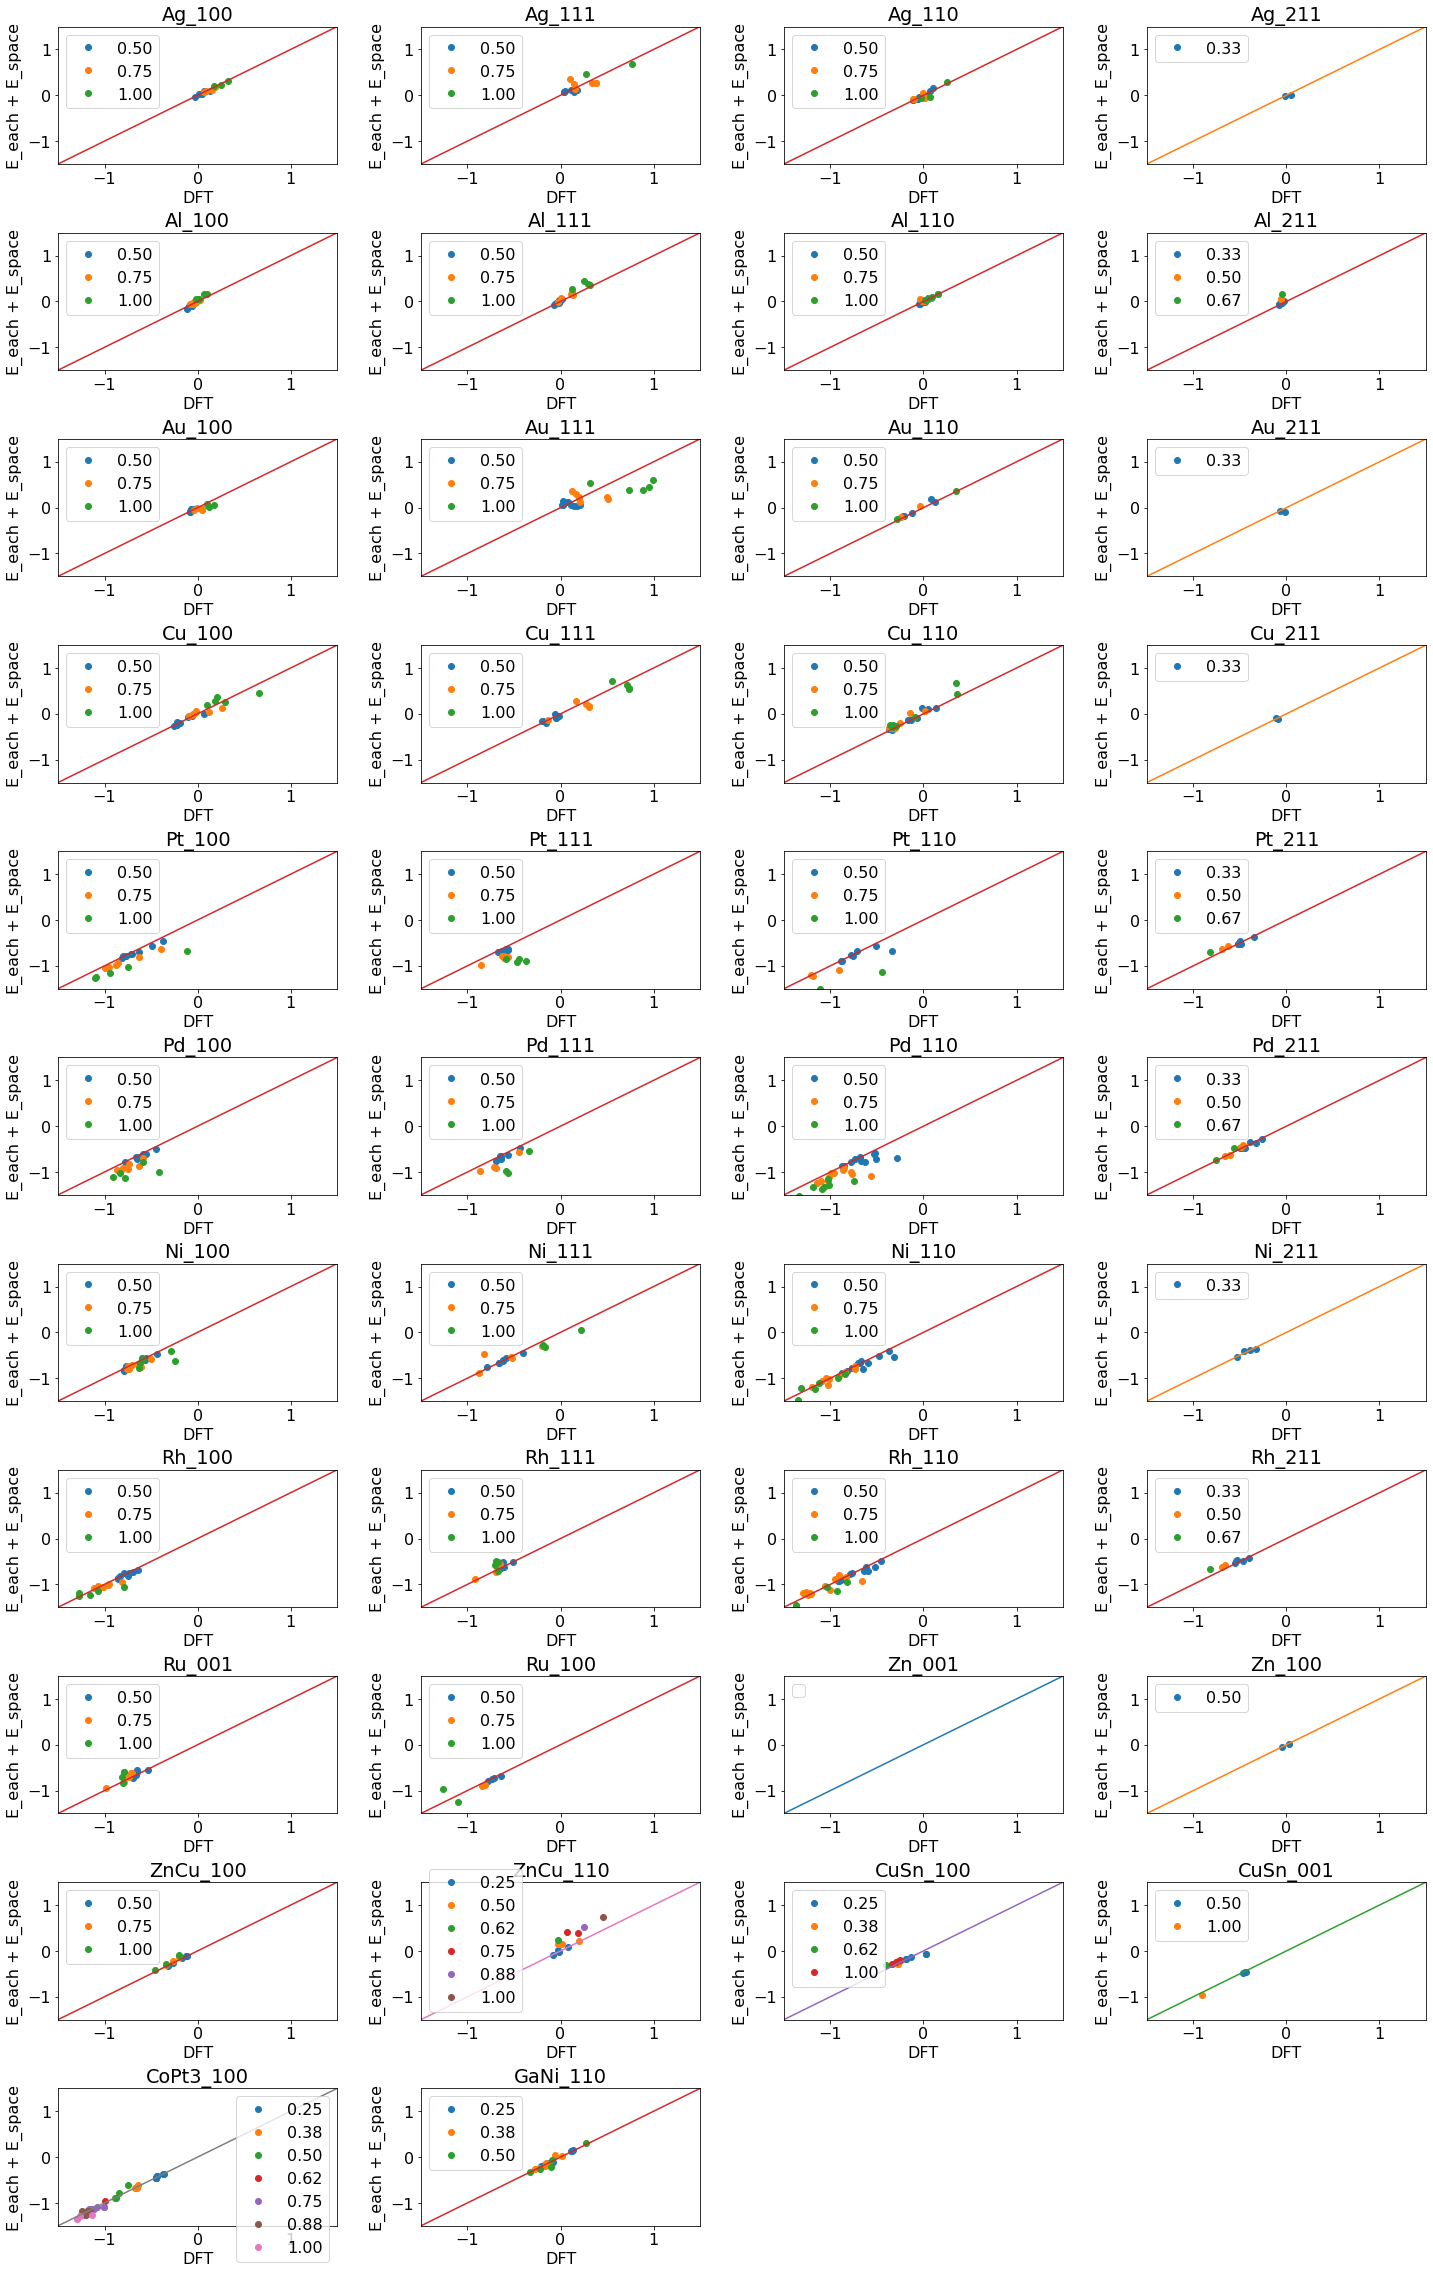

In [8]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        if not covset[i][j]:
            continue
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        aveadsE_suratom = np.array(data['aveadsE/suratom'])
        E_residue = np.array(data['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
   
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    aveadsE_suratom = np.array(data['aveadsE/suratom'])
    E_residue = np.array(data['E_residue/suratom'])
    E_prepred = aveadsE_suratom - E_residue    
    print(dictlis[i]['element'], dictlis[i]['face'], mean_squared_error(aveadsE_suratom, E_prepred))
    
# plt.savefig('E_residue.png', bbox_inches='tight')
plt.show()

In [9]:
file = 'CuSn_001_u2_RPBE_no004_CO_n1_d14' + '.traj'
init_query(file,'local')
query(file,'local')

Atoms(symbols='Cu2Sn2Cu2Sn2Cu2Sn2Cu2Sn2CO', pbc=[True, True, False], cell=[[8.467951928850718, 0.0, 5e-16], [-4.2339759644253565, 7.333461488410161, 5e-16], [0.0, 0.0, 41.27197734637267]], tags=..., constraint=FixAtoms(indices=[1, 2, 5, 6, 9, 10, 13, 14]), calculator=SinglePointCalculator(...))

In [10]:
dfpred[-7]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e8f6cbcccbb54a830f7a88c,Zn_100_u2_RPBE_no675_CO_n2_d3.traj,yes,yes,Zn,100,2,RPBE,CO,2,0.5,4,-36.311582,-7.454759,-14.485436,0.114050,0.028513,0.057025,0.002680,0.079711,0.007915,56.863306,0.035172,"[1, 1]","[1, 1]",yes,yes,yes,yes,Over 4,0.0,0.0
1,5e8f6cddccbb54a830f7a89a,Zn_100_u2_RPBE_no995_CO_n2_d3.traj,yes,yes,Zn,100,2,RPBE,CO,2,0.5,4,-36.597596,-7.454759,-14.485436,-0.171964,-0.042991,-0.085982,-0.003131,-0.190836,0.005501,56.863306,0.035172,"[3, 1]","[3, 1]",yes,yes,yes,yes,3,0.0,2.0


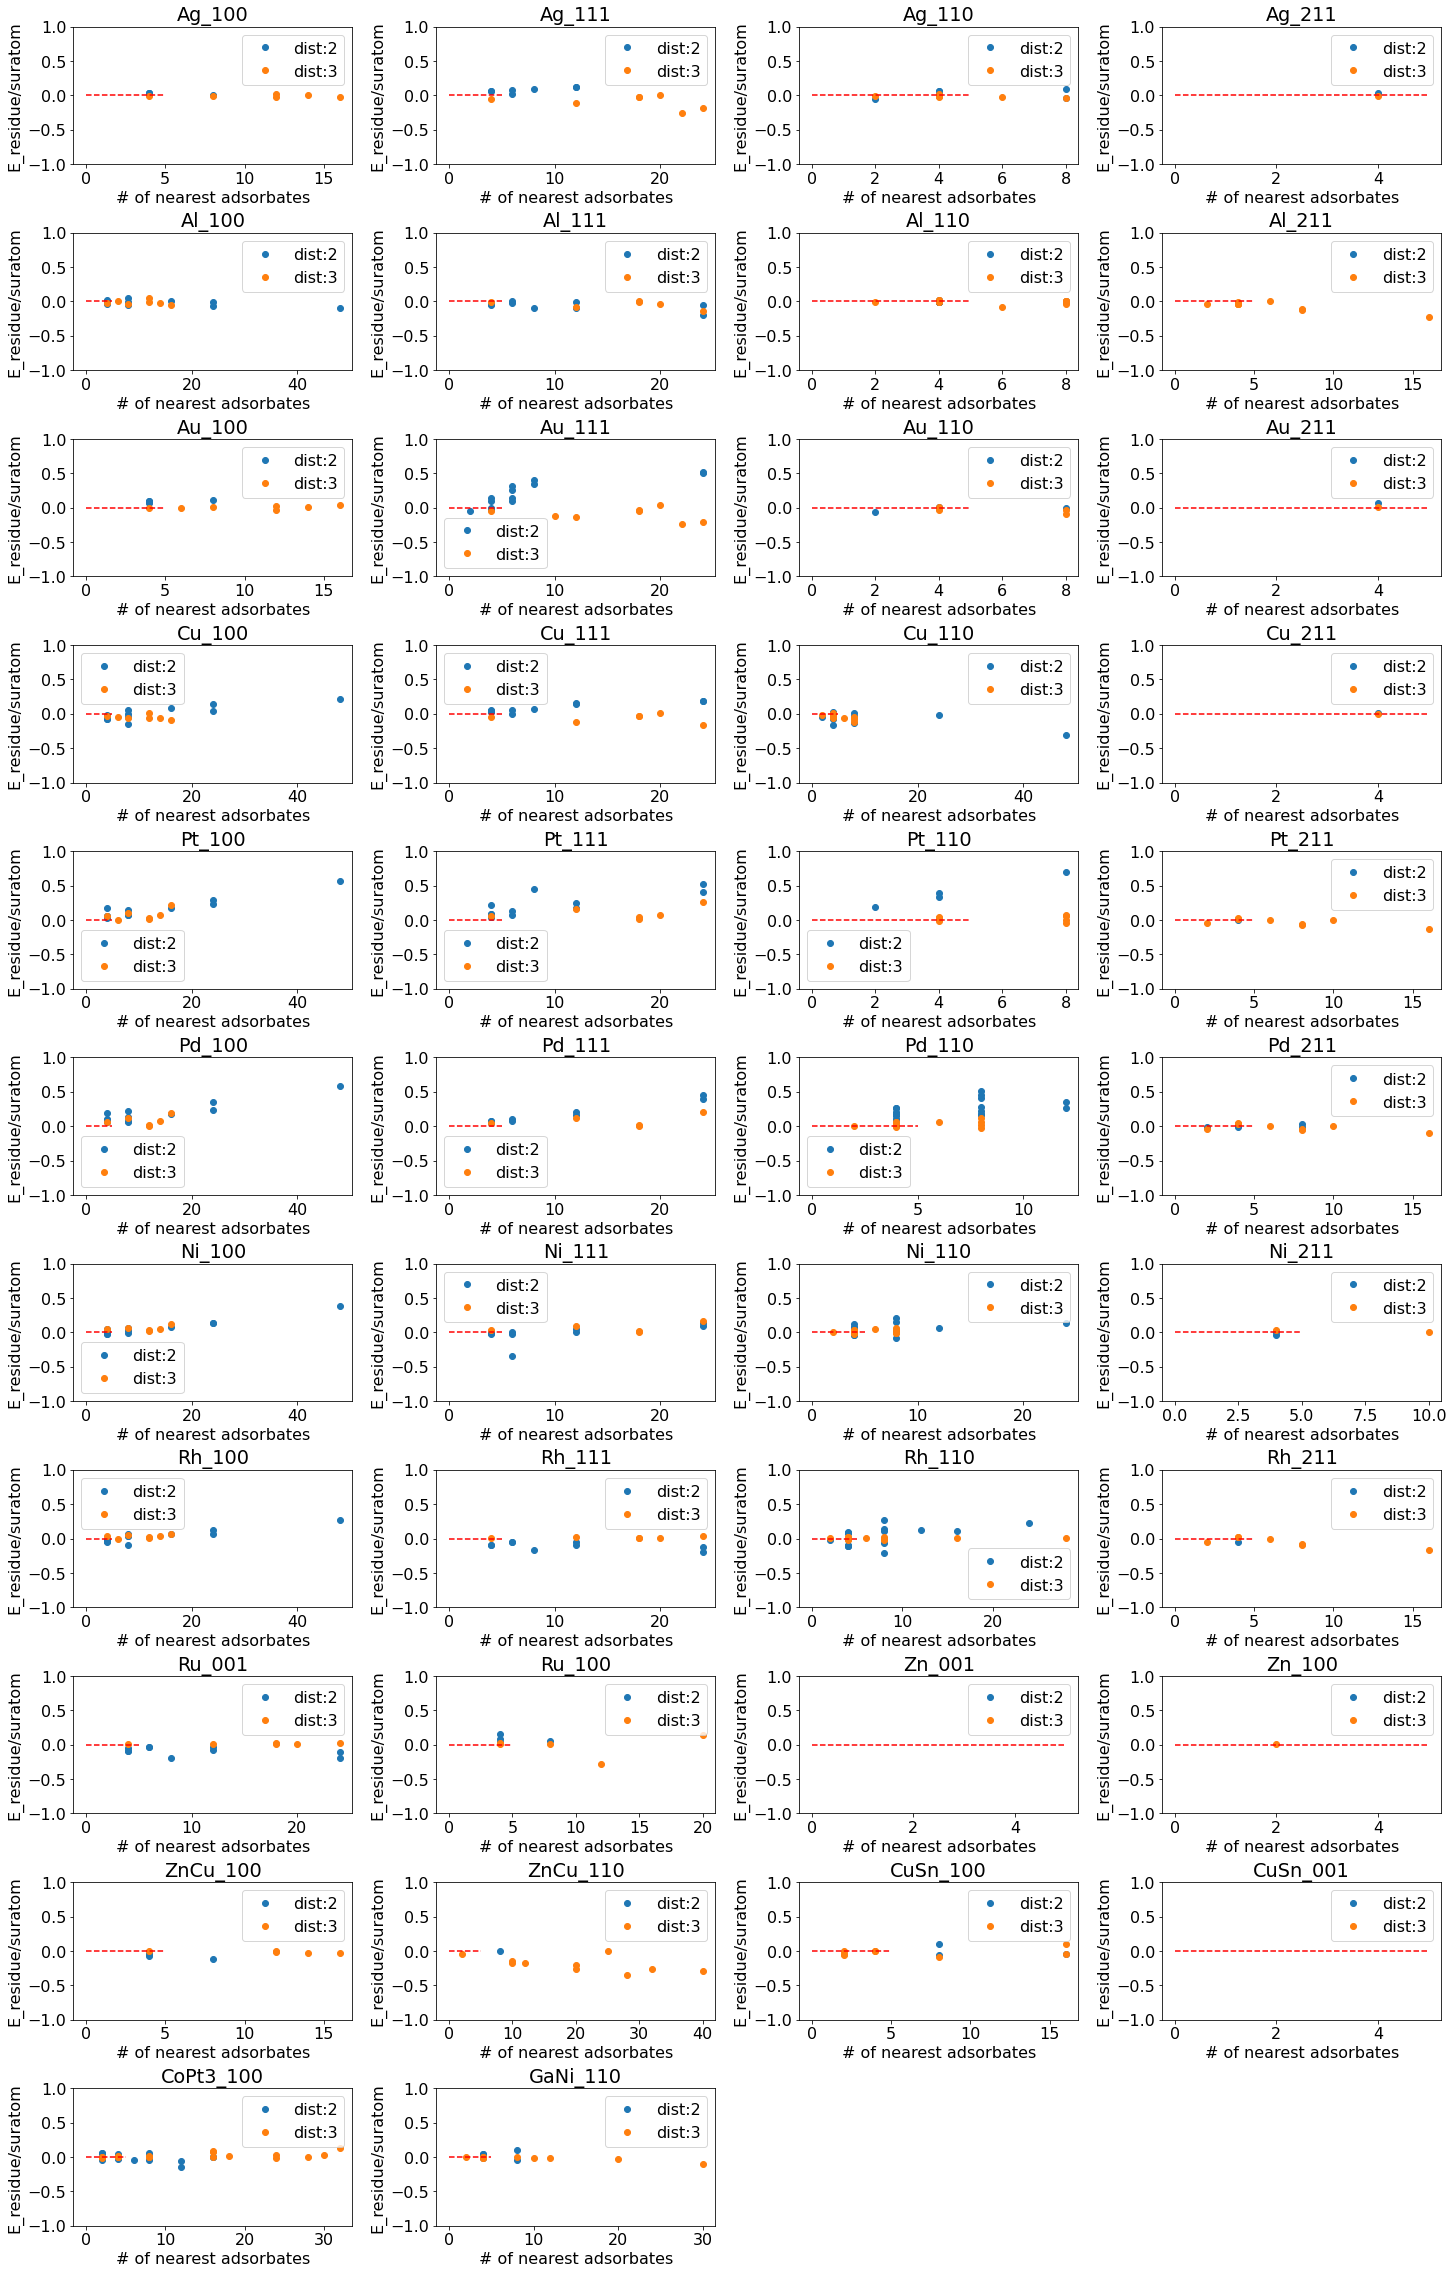

In [10]:
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16


xmin = 0
xmax = 5
for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
  #  plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

In [11]:
file = 'CuSn_001_u2_RPBE_no028_CO_n4_d6' + '.traj'
init_query(file,'local')
query(file,'local')

Atoms(symbols='Cu2Sn2Cu2Sn2Cu2Sn2Cu2Sn2COCOCOCO', pbc=[True, True, False], cell=[[8.467951928850718, 0.0, 5e-16], [-4.2339759644253565, 7.333461488410161, 5e-16], [0.0, 0.0, 41.27197734637267]], tags=..., constraint=FixAtoms(indices=[1, 2, 5, 6, 9, 10, 13, 14]), calculator=SinglePointCalculator(...))

### Parameters are specific to material and face

Ag 100 0.00025361833127206186 0.007113421211890387 -0.0005605616463416353
Ag 111 0.008655323363030064 0.03474229788162562 -0.005464370399030133
Ag 110 0.0009442920194665266 0.012630303254717463 -0.00395590979166675
Ag 211 0.0 0.011359165000000154 -0.0020006741666670123
Al 100 0.0009398227282473089 0.000526262485708955 -0.0013866197780373914
Al 111 0.0024209905491290136 0.005042378029424679 -0.0029872548486549674
Al 110 0.0004730868611998568 0.0025593492058686054 -0.0014874185505321215
Al 211 0.0010010797954535964 0.007429096375661094 -0.01215610637566096
Au 100 0.00042942892942170413 0.01555980783330948 0.0006109059988318009
Au 111 0.025546320658531654 0.045535692633188234 -0.00579572024070965
Au 110 0.002841441545631717 0.020259415047619224 -0.007337364625000252
Au 211 6.018531076210112e-36 0.016513510416666488 0.0017912275000000477
Cu 100 0.0013282480330616688 0.010908877700684475 -0.004355023399532992
Cu 111 0.004488775090367284 0.020783512645562205 -0.003567758433295868
Cu 110 0.00

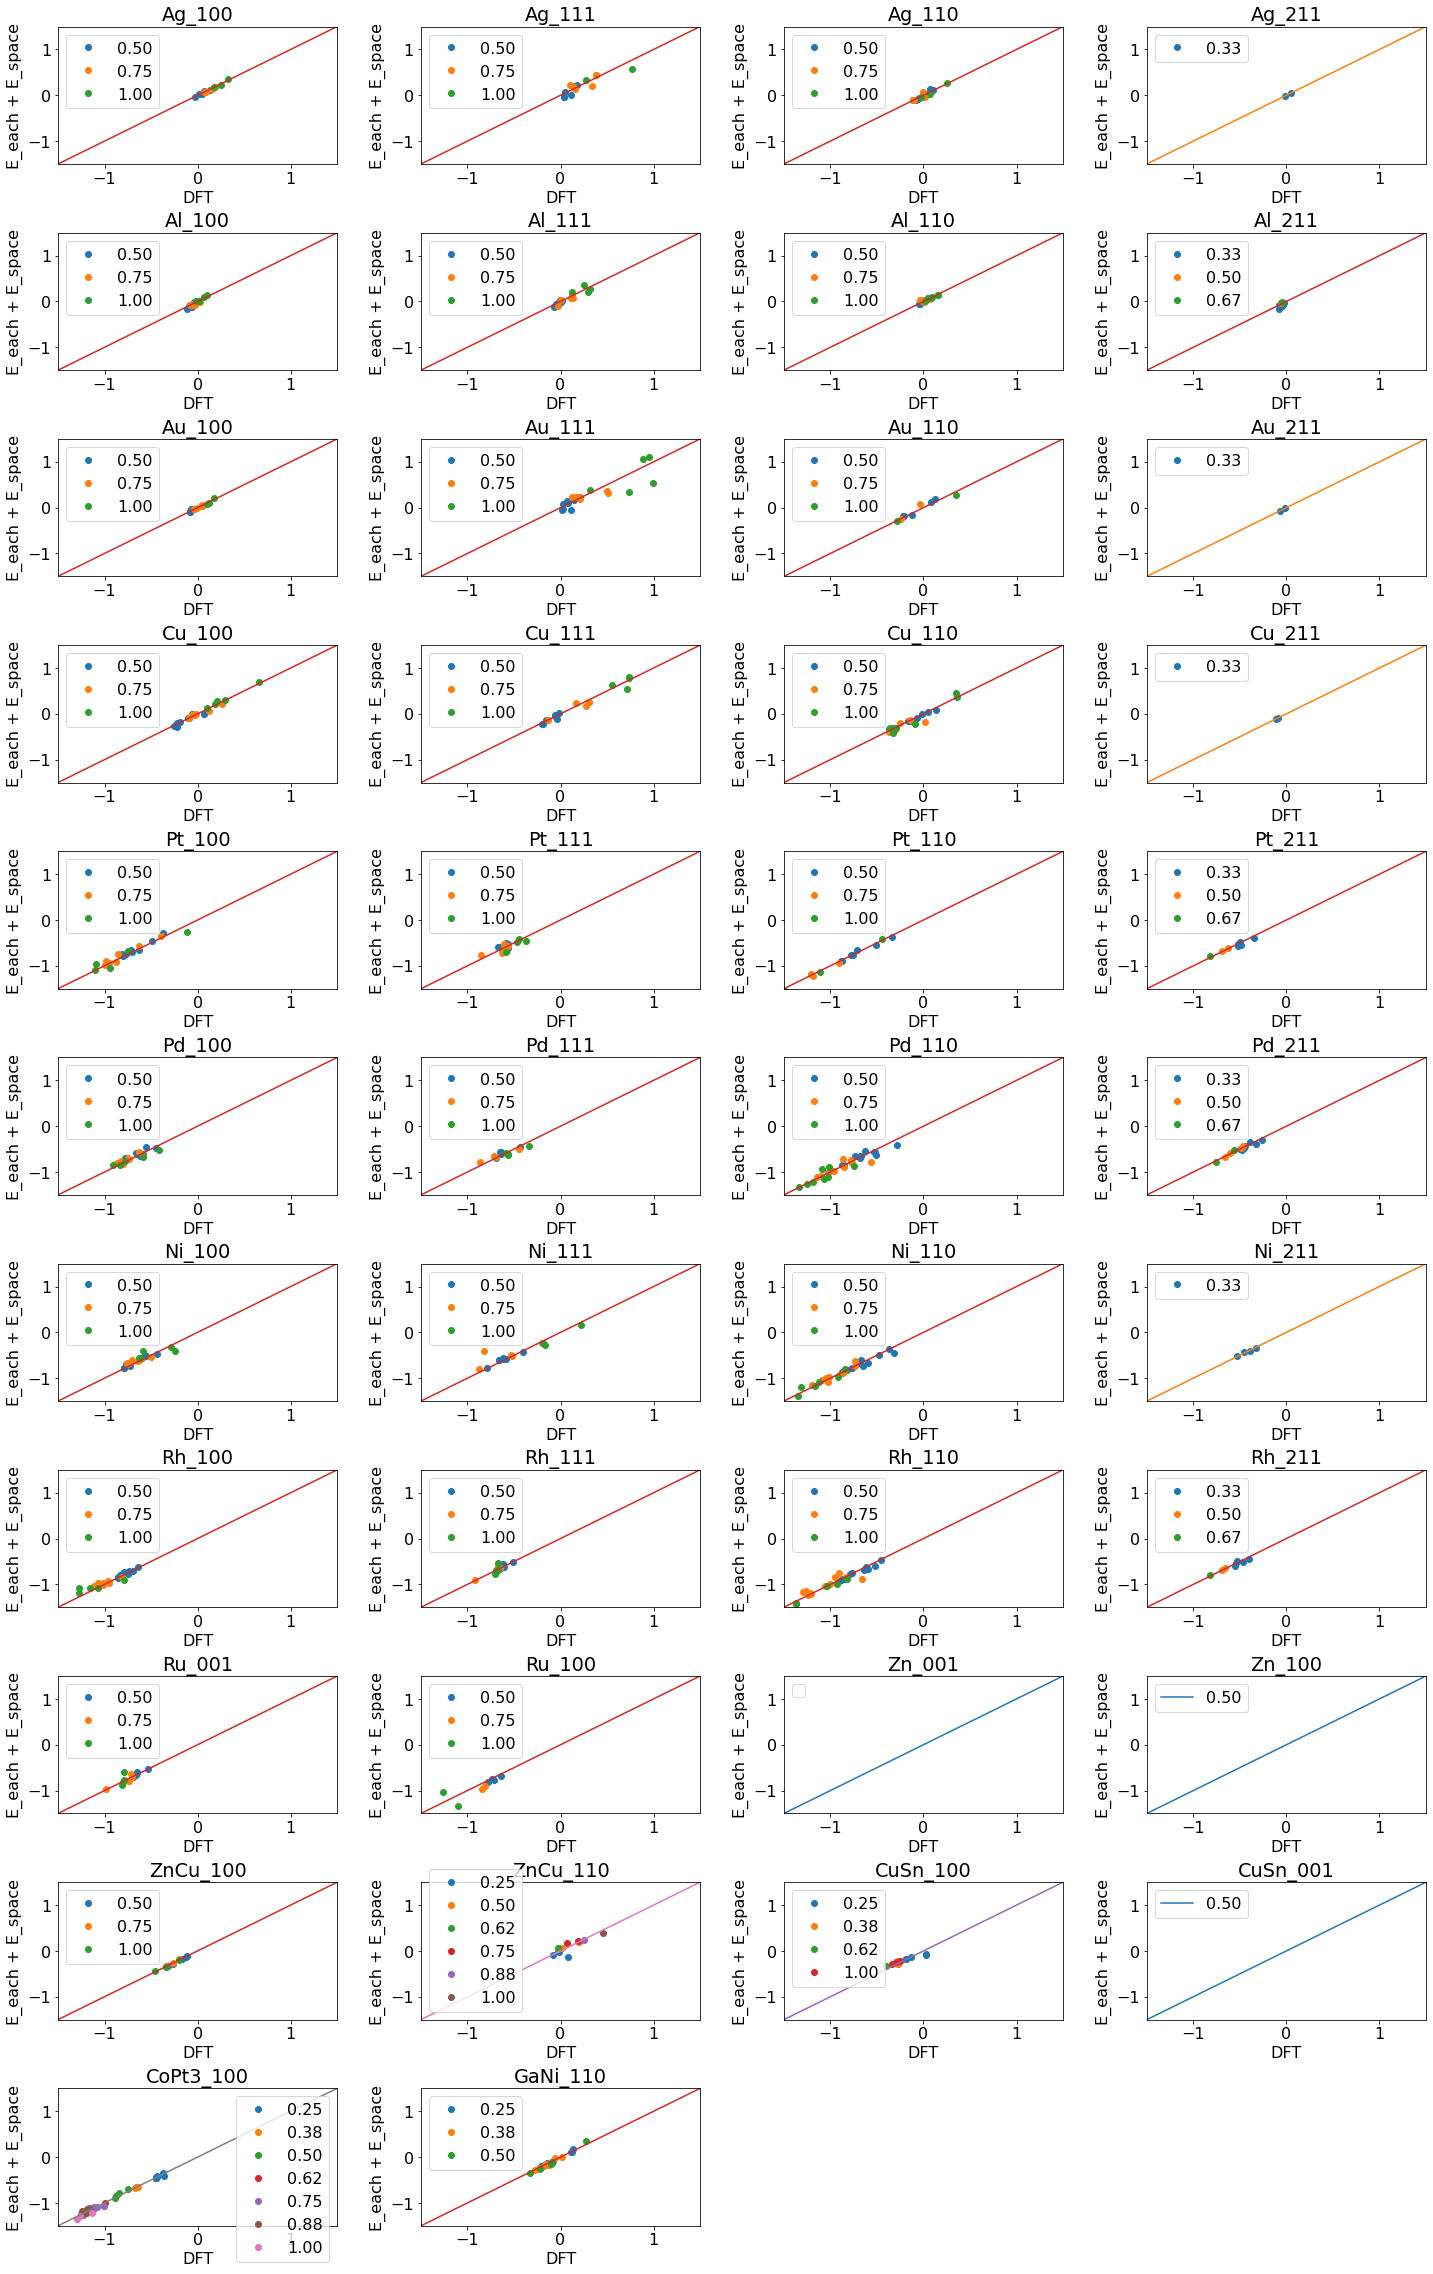

In [12]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        try:
            weight2, weight3 = inst[i].fit_weight_from_specific_element_and_face()
            data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]

            E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
            E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

            aveadsE_suratom = data['aveadsE/suratom']
            if not aveadsE_suratom.any():
                continue
            if xmin > np.min(aveadsE_suratom):
                xmin = np.min(aveadsE_suratom)
            if xmax < np.max(aveadsE_suratom):
                xmax = np.max(aveadsE_suratom)
            ax.plot(aveadsE_suratom, E_ads_pred, 'o')
        except:
            print('Some error')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
    E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred
    aveadsE_suratom = data['aveadsE/suratom']    
    print(dictlis[i]['element'], dictlis[i]['face'], mean_squared_error(aveadsE_suratom, E_ads_pred), weight2[0], weight3[0])

# plt.savefig('E_pred_wmf_method3.png', bbox_inches='tight')
# plt.show()

In [17]:
dfpred[-4]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e8f6188ccbb54a830f7a4c4,CuSn_100_u2_RPBE_no008_CO_n8_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,8,1.000,8,-217.606754,-99.047199,-14.485436,-2.676064,-0.334508,-0.334508,3.500812,-5.773986,-0.050361,87.37228,0.091562,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",yes,yes,yes,yes,3,0.0,16.0
1,5e8f619dccbb54a830f7a4c8,CuSn_100_u2_RPBE_no019_CO_n8_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,8,1.000,8,-217.331207,-99.047199,-14.485436,-2.400517,-0.300065,-0.300065,3.506584,-5.428963,-0.059767,87.37228,0.091562,"[1, 1, 4, 4, 0, 0, 0, 0]","[1, 1, 4, 4, 0, 0, 0, 0]",yes,yes,yes,yes,2,8.0,16.0
2,5e8f61bcccbb54a830f7a4ce,CuSn_100_u2_RPBE_no1014_CO_n2_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,2,0.250,8,-127.814592,-99.047199,-14.485436,0.203480,0.025435,0.101740,0.004499,-0.585494,0.098059,87.37228,0.022891,"[5, 5]","[5, 5]",yes,yes,yes,yes,3,0.0,16.0
3,5e8f61c5ccbb54a830f7a4d0,CuSn_100_u2_RPBE_no1015_CO_n2_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,2,0.250,8,-127.840749,-99.047199,-14.485436,0.177323,0.022165,0.088662,-0.007674,-0.585494,0.096311,87.37228,0.022891,"[5, 5]","[5, 5]",yes,yes,yes,yes,2,8.0,0.0
4,5e8f61ceccbb54a830f7a4d2,CuSn_100_u2_RPBE_no116_CO_n5_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,5,0.625,8,-174.725259,-99.047199,-14.485436,-3.250878,-0.406360,-0.650176,0.872145,-3.414712,-0.088539,87.37228,0.057226,"[4, 0, 0, 0, 0]","[4, 0, 0, 0, 0]",yes,yes,yes,yes,3,0.0,8.0
5,5e8f6200ccbb54a830f7a4dc,CuSn_100_u2_RPBE_no206_CO_n3_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,3,0.375,8,-144.562747,-99.047199,-14.485436,-2.059238,-0.257405,-0.686413,0.433494,-2.186762,-0.038246,87.37228,0.034336,"[1, 0, 0]","[1, 0, 0]",yes,yes,yes,yes,3,0.0,2.0
6,5e8f6209ccbb54a830f7a4de,CuSn_100_u2_RPBE_no218_CO_n3_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,3,0.375,8,-144.653191,-99.047199,-14.485436,-2.149683,-0.268710,-0.716561,-0.002681,-2.165245,0.002280,87.37228,0.034336,"[0, 0, 0]","[0, 0, 0]",yes,yes,yes,yes,Over 4,0.0,0.0
7,5e8f6231ccbb54a830f7a4e6,CuSn_100_u2_RPBE_no303_CO_n3_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,3,0.375,8,-144.699749,-99.047199,-14.485436,-2.196241,-0.274530,-0.732080,0.431807,-2.165245,-0.057850,87.37228,0.034336,"[0, 0, 0]","[0, 0, 0]",yes,yes,yes,yes,3,0.0,2.0
8,5e8f6268ccbb54a830f7a4f2,CuSn_100_u2_RPBE_no710_CO_n3_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,3,0.375,8,-144.731274,-99.047199,-14.485436,-2.227766,-0.278471,-0.742589,-0.005071,-2.208279,-0.001802,87.37228,0.034336,"[1, 1, 0]","[1, 1, 0]",yes,yes,yes,yes,3,0.0,2.0
9,5e8f6270ccbb54a830f7a4f4,CuSn_100_u2_RPBE_no725_CO_n8_d3.traj,yes,yes,CuSn,100,2,RPBE,CO,8,1.000,8,-216.930249,-99.047199,-14.485436,-1.999559,-0.249945,-0.249945,3.500858,-5.083940,-0.052060,87.37228,0.091562,"[1, 1, 1, 4, 4, 4, 4, 1]","[1, 1, 1, 4, 4, 4, 4, 1]",yes,yes,yes,yes,2,16.0,16.0


In [13]:
dfpred[9][dfpred[9]['coverage']==1.00]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
2,5e7e2d2ba222761ffba74925,Au_111_u2_RPBE_no004_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-86.250727,-29.59572,-14.485436,1.286738,0.321684,0.321684,1.555925,0.554171,-0.205839,30.515702,0.13108,"[0, 0, 0, 0]","[0, 0, 0, 0]",yes,yes,yes,yes,3,0.0,24.0
11,5e7e2d80a222761ffba74941,Au_111_u2_RPBE_no019_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-84.616088,-29.59572,-14.485436,2.921377,0.730344,0.730344,1.555927,0.006931,0.339630,30.515702,0.13108,"[1, 1, 1, 1]","[1, 1, 1, 1]",yes,yes,yes,yes,2,8.0,72.0
12,5e7e2d91a222761ffba74945,Au_111_u2_RPBE_no021_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-83.549198,-29.59572,-14.485436,3.988267,0.997067,0.997067,2.380638,0.006931,0.400175,30.515702,0.13108,"[1, 1, 1, 1]","[1, 1, 1, 1]",yes,yes,yes,yes,2,8.0,72.0
18,5e7e2dc9a222761ffba74957,Au_111_u2_RPBE_no031_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-84.009429,-29.59572,-14.485436,3.528035,0.882009,0.882009,1.555593,-0.034824,0.501817,30.515702,0.13108,"[2, 2, 2, 2]","[2, 2, 2, 2]",yes,yes,yes,yes,2,24.0,72.0
20,5e7e2ddca222761ffba7495d,Au_111_u2_RPBE_no035_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-83.723580,-29.59572,-14.485436,3.813885,0.953471,0.953471,1.555593,0.203265,0.513757,30.515702,0.13108,"[3, 3, 3, 3]","[3, 3, 3, 3]",yes,yes,yes,yes,2,24.0,72.0


In [14]:
file = 'Au_111_u2_RPBE_no035_CO_n4_d3'+'.traj'
query(file,'local')

Atoms(symbols='Au12COCOCOCO', pbc=[True, True, False], cell=[[5.936033815339043, 0.0, 4e-16], [-2.9680169076695235, 5.140756081807076, 4e-16], [0.0, 0.0, 36.35063485871771]], tags=..., constraint=FixAtoms(indices=[0, 3, 6, 9]), calculator=SinglePointCalculator(...))

### Parameters are only specific to material

In [15]:
# xrange = np.linspace(-2, 2)
# # predadsene_surf, adsElis, Eint
# fig = plt.figure(figsize=(figs[0],figs[1]))
# plt.rcParams["font.size"] = 16

# for i in range(len(dfpred)):
#     ax = fig.add_subplot(fign[0],fign[1], i+1)
#     xmin = 100
#     xmax = -100

#     for j in range(len(covset[i])):
#         weight2, weight3 = inst[i].fit_weight_from_specific_element()
#         data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
#         E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
#         E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

#         aveadsE_suratom = data['aveadsE/suratom']
#         if not aveadsE_suratom.any():
#             continue
#         if xmin > np.min(aveadsE_suratom):
#             xmin = np.min(aveadsE_suratom)
#         if xmax < np.max(aveadsE_suratom):
#             xmax = np.max(aveadsE_suratom)
#         ax.plot(aveadsE_suratom, E_ads_pred, 'o')
#     ax.plot(xrange, xrange, '-')

#     plt.xlim(-1.5, 1.5)
#     plt.ylim(-1.5, 1.5)
#     ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
# #     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
#     ax.set_xlabel('DFT')
#     ax.set_ylabel('E_each + E_space')
# #     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
#     plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
#     if not covset[i]:
#         continue
#     data = dfpred[i]
#     E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
#     E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred
#     aveadsE_suratom = data['aveadsE/suratom']    
#     print(dictlis[i]['element'], dictlis[i]['face'], mean_squared_error(aveadsE_suratom, E_ads_pred))

# # plt.savefig('E_pred_wm_method2.png', bbox_inches='tight')
# # plt.show()

In [38]:
dfall[-8]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e7e7a63a222761ffba750c6,Zn_001_u2_RPBE_no001_CO_n1_d8.traj,no,no,Zn,001,2,RPBE,CO,1,0.25,4,-25.701166,-11.224569,-14.485436,0.008839,0.002210,0.008839,0.000348,None,None,24.539239,0.040751,[0],[0],yes,no,yes,yes,Over 4,0.0,0.0
1,5e7e7a64a222761ffba750c8,Zn_001_u2_RPBE_no002_CO_n1_d8.traj,no,no,Zn,001,2,RPBE,CO,1,0.25,4,-25.731509,-11.224569,-14.485436,-0.021504,-0.005376,-0.021504,0.000348,None,None,24.539239,0.040751,[1],[2],yes,no,no,yes,3,0.0,6.0
2,5e7e7a65a222761ffba750ca,Zn_001_u2_RPBE_no003_CO_n1_d8.traj,no,no,Zn,001,2,RPBE,CO,1,0.25,4,-25.710145,-11.224569,-14.485436,-0.000140,-0.000035,-0.000140,0.000348,None,None,24.539239,0.040751,[2],[2],yes,no,yes,yes,3,0.0,6.0
3,5e7e7a65a222761ffba750cc,Zn_001_u2_RPBE_no004_CO_n1_d8.traj,no,no,Zn,001,2,RPBE,CO,1,0.25,4,-25.707024,-11.224569,-14.485436,0.002981,0.000745,0.002981,0.000348,None,None,24.539239,0.040751,[3],[3],yes,no,yes,yes,3,0.0,6.0


In [39]:
file = 'Zn_001_u2_RPBE_no001_CO_n1_d8_all' + '.traj'
query(file,'local')

Atoms(symbols='Zn16CO', pbc=True, cell=[[5.32310738, 0.0, 0.0], [-2.66155369, 4.60994622, 0.0], [0.0, 0.0, 37.38823143]], constraint=FixAtoms(indices=[0, 1, 4, 5, 8, 9, 12, 13]), calculator=SinglePointCalculator(...))